## Abstract

The goal of our project is to see how likely a patient who suffers from diabetes is to return to a hospital after discharge, based on a sample of about 80,000 people. The data includes demographic information, laboratory testing done while the patient was in the hospital and a few more variables. We will use different machine learning algorithms (e.g. Logistic Regression, Random Forest) to predict patient readmission. In addition, we will use Linear Probability model to understand the exact impact of independent variables on our dependent variable and Logistic Regression to see
whether the features have the same influence on males and females regarding their readmission to the hospital.

### Motivation

In US hospitals, readmission is usually considered a measure of quality check for the hospitals, because in case of proper medical treatment, readmission rates are likely to be low. In addition, as many hospitals have capacity limitations and constant need of optmimization, understanding whether the patient will return or not within a specific time period can solve logistic and resource utilization problems.

### Importing libraries

In [141]:
import pandas as pd
import numpy as np

import plotly as ply
import plotly.plotly as py
import plotly.figure_factory as ff
ply.offline.init_notebook_mode(connected=True)

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

import scipy.stats as stats

import statsmodels.api as sm

%matplotlib inline

In [142]:
pd.set_option('display.max_columns', 500)
#ply.tools.set_credentials_file(username='karengishyan', api_key='sPpmUiFypulPlsLHcy6l')
ply.tools.set_credentials_file(username='dvmartirosyan', api_key='GuoIe9Os3ECwJAJX629I')

## Descriptive Analytics

In [143]:
data = pd.read_csv("data.csv")

In [144]:
data.head(5)

,race,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,disch_disp_modified,adm_src_mod,adm_typ_mod,age_mod,diag1_mod,diag2_mod,diag3_mod,readmission
0,Caucasian,Female,13,68,2,28,0,0,0,8,None,None,No,No,Steady,No,No,No,Steady,Ch,Yes,Discharged to home,Other,Urgent,80+,Other,427,Other,NO
1,Caucasian,Female,12,33,3,18,0,0,0,8,None,None,No,No,No,No,No,Steady,Steady,Ch,Yes,Discharged/Transferred to SNF,Other,Elective,80+,434,Other,Other,NO
2,Caucasian,Male,1,51,0,8,0,0,0,5,None,None,No,No,Steady,No,No,No,Steady,Ch,Yes,Discharged to home,Emergency Room,Emergency,20-59,Other,Other,250,NO
3,AfricanAmerican,Female,9,47,2,17,0,0,0,9,None,None,No,No,No,No,No,No,Steady,No,Yes,Discharged to home,Emergency Room,Emergency,20-59,Other,403,Other,YES
4,AfricanAmerican,Male,7,62,0,11,0,0,0,7,None,None,No,No,No,Up,No,No,Steady,Ch,Yes,Discharged to home,Other,Urgent,60-79,Other,Other,Other,YES


In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81414 entries, 0 to 81413
Data columns (total 29 columns):
race                   81414 non-null object
gender                 81414 non-null object
time_in_hospital       81414 non-null int64
num_lab_procedures     81414 non-null int64
num_procedures         81414 non-null int64
num_medications        81414 non-null int64
number_outpatient      81414 non-null int64
number_emergency       81414 non-null int64
number_inpatient       81414 non-null int64
number_diagnoses       81414 non-null int64
max_glu_serum          81414 non-null object
A1Cresult              81414 non-null object
metformin              81414 non-null object
glimepiride            81414 non-null object
glipizide              81414 non-null object
glyburide              81414 non-null object
pioglitazone           81414 non-null object
rosiglitazone          81414 non-null object
insulin                81414 non-null object
change                 81414 non-null object

In [146]:
# Splitting data into numeric and non-numeric parts
data_numeric = data.select_dtypes(exclude=["object"])
data_obj = data.select_dtypes(include=["object"])

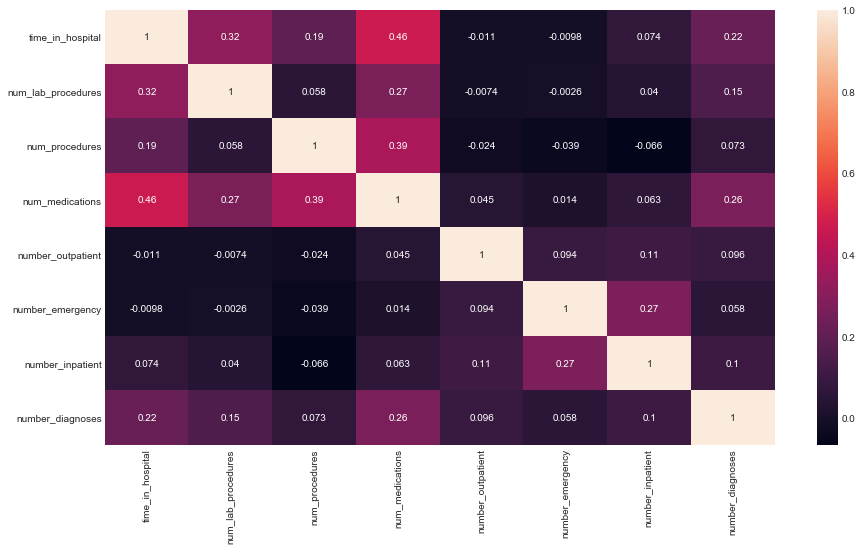

In [147]:
plt.figure(figsize=(15,8))
sns.heatmap(data_numeric.corr(),annot=True);
# As we can see from above, there are no high correlated variables.

In [148]:
# Checking the frequency of "YES" vs "NO" values in readmission column. As we can see the classes are quite balanced.
data_obj.readmission.value_counts()

NO     43892
YES    37522
Name: readmission, dtype: int64

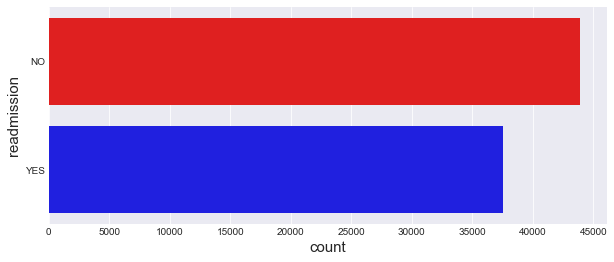

In [149]:
# Visualizing
plt.figure(figsize=(10,4))
sns.set_style("darkgrid")
g = sns.countplot(y=data_obj.readmission,palette=['red','blue'])
g.set(xticks=list(range(0,50000,5000)))
g.set_ylabel('readmission', fontsize=15)
g.set_xlabel('count', fontsize=15);

In [150]:
x = data_numeric[['time_in_hospital','num_lab_procedures','num_medications','number_diagnoses']]
l = []
for col in x.columns:
    l.append(go.Box( y=x[col], name=col, showlegend=False ) )
l.append(go.Scatter( x = x.columns, y = x.mean(), mode='lines', name='mean' ) )
py.iplot(l, filename='pandas-box-plot.html') # if this code does not work, 
# try plot(l, filename='pandas-box-plot.html')

/Users/davitmartirosyan/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:224: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~dvmartirosyan/0 or inside your plot.ly account where it is named 'pandas-box-plot.html'


In [151]:
x = ['metformin', 'insulin','glimepiride','glipizide','pioglitazone','rosiglitazone','glyburide']
y1 = [65374,37965,77240,71291,75515,76262,72860]
y2 = [14706,24642,3744,9077,5611,4938,7457]
y3=  [478,9775,161,428,96,69,442]
y4=  [856,9032,269,618,192,145,655]
Trace1 = go.Bar(
    x=x,
    y=y1,
    text=y1,
    textposition = 'auto',
    marker=dict(
        color='rgb(158,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6,name='No'
)

Trace2 = go.Bar(
    x=x,
    y=y2,
    text=y2,
    textposition = 'auto',
    marker=dict(
        color='rgb(178,223,138)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6,name='Steady'
)
Trace3 = go.Bar(
    x=x,
    y=y3,
    text=y3,
    textposition = 'auto',
    marker=dict(
        color='rgb(254,224,144)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6,name='Down'
)
Trace4 = go.Bar(
    x=x,
    y=y4,
    text=y4,
    textposition = 'auto',
    marker=dict(
        color='rgb(215,48,39)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.5),
        ),
    opacity=0.6, name='Up'
)


l = [Trace1,Trace2,Trace3,Trace4]

py.iplot(l, filename='grouped-bar-direct-labels')

# As we can see from the figure below, insulin was the most used medication for patients in terms of all 
# categories, which is not very surprising since insulin is known to be very important for diabatic patients :)
# "up” - if the dosage was increased during the encounter
# “down” - if the dosage was decreased, 
# “steady” - if the dosage did not change,
# “no” - if the drug was not prescribe.

diag1_mod, diag2_mod, and diag3_mod stand for the primary, secondary and additional secondary diagnosis (coded as first three digits of ICD9) respectively. We decided to drop those columns because
1. These columns contain diagnosis codes which are not interpretable
2. These columns besides containing numeric values also contain one categorical value, namely 'Other', which cannot be substituted by some number without distort the meaning of the column

In [152]:
data = data.drop(['diag1_mod','diag2_mod','diag3_mod'],axis=1)

#### Finding and Dealing with Missing Values

In [153]:
data_obj.gender.value_counts()
# As we can see we have 2 Unknown/Invalid values

Female             43755
Male               37657
Unknown/Invalid        2
Name: gender, dtype: int64

In [154]:
# Dropping the rows that have missing values in gender column
data = data.loc[data.gender!='Unknown/Invalid']

In [155]:
data.gender.value_counts()
# checking that we have dropped the rows successfully

Female    43755
Male      37657
Name: gender, dtype: int64

In [156]:
data.race.value_counts()
# As we can see there are 1852 'Unknown' values in race column. We have decided to drop all of those rows, 
# because our dataset is large enough relative to the number of unknown rows and also since race column contains
# only few categories, we believe that filling the column will distort the nature of the column

Caucasian          60804
AfricanAmerican    15440
Unknown             1852
Hispanic            1633
Other               1169
Asian                514
Name: race, dtype: int64

In [157]:
# Dropping the rows that have unknown values in race column
data=data.loc[data.race!='Unknown']

In [158]:
data.race.value_counts()
# checking that we have dropped the rows successfully

Caucasian          60804
AfricanAmerican    15440
Hispanic            1633
Other               1169
Asian                514
Name: race, dtype: int64

#### Data preprocessing

In [159]:
# Encoding categories
data.age_mod = data.age_mod.astype('category').cat.reorder_categories(["0-19","20-59","60-79","80+"]).cat.codes
data.gender = data.gender.astype('category').cat.reorder_categories(["Female","Male"]).cat.codes
data.change = data.change.astype('category').cat.reorder_categories(["No","Ch"]).cat.codes
data.diabetesMed = data.diabetesMed.astype('category').cat.reorder_categories(["No","Yes"]).cat.codes
data.readmission = data.readmission.astype('category').cat.reorder_categories(["NO","YES"]).cat.codes

In [160]:
# Getting dummies
race = pd.get_dummies(data.race)

glucose_level = pd.get_dummies(data.max_glu_serum)
a1c_result = pd.get_dummies(data.A1Cresult)
metformin_ = pd.get_dummies(data.metformin)
glimepiride_ = pd.get_dummies(data.glimepiride)
glipizide_ = pd.get_dummies(data.glipizide)
glyburide_ = pd.get_dummies(data.glyburide)
pioglitazone_ = pd.get_dummies(data.pioglitazone)
rosiglitazone_ = pd.get_dummies(data.rosiglitazone)
insulin_ = pd.get_dummies(data.insulin)

discharge_disposition = pd.get_dummies(data.disch_disp_modified)
admission_source = pd.get_dummies(data.adm_src_mod)
admission_type = pd.get_dummies(data.adm_typ_mod)

In [161]:
# Dropping the columns we have got dummies from
data = data.drop(['max_glu_serum','A1Cresult','metformin',
                  'glimepiride','glipizide','glyburide',
                  'pioglitazone','rosiglitazone','insulin',
                  'disch_disp_modified','adm_src_mod','adm_typ_mod','race'],axis=1)

In [162]:
# Dealing with dummy trap
race = race.drop(['Other'],axis=1)
glucose_level = glucose_level.drop(['None'],axis=1)
a1c_result = a1c_result.drop(['None'],axis=1)
metformin_ = metformin_.drop(['No'],axis=1)
glimepiride_ = glimepiride_.drop(['No'],axis=1)
glipizide_ = glipizide_.drop(['No'],axis=1)
glyburide_ = glyburide_.drop(['No'],axis=1)
pioglitazone_ = pioglitazone_.drop(['No'],axis=1)
rosiglitazone_ = rosiglitazone_.drop(['No'],axis=1)
insulin_ = insulin_.drop(['No'],axis=1)
discharge_disposition = discharge_disposition.drop(['Other'],axis=1)
admission_source = admission_source.drop(['Other'],axis=1)
admission_type = admission_type.drop(['Other'],axis=1)

In [163]:
# Renaming some columns to not have errors when joining
glucose_level = glucose_level.rename(columns={'Norm':'max_glu_serum_result_norm','>200':'max_glu_serum_result(200,300]','>300':'A1C_result>300'})
a1c_result = a1c_result.rename(columns={'Norm':'A1C_result_norm','>7':'A1C_result(7,8]','>8':'A1C_result>8'})

metformin_ = metformin_.rename(columns={'Steady':'metformin_steady','Up':'metformin_up','Down':'metformin_down'})
glimepiride_ = glimepiride_.rename(columns={'Steady':'glimepiride_steady','Up':'glimepiride_up','Down':'glimepiride_down'})
glipizide_ = glipizide_.rename(columns={'Steady':'glipizide_steady','Up':'glipizide_up','Down':'glipizide_down'})
glyburide_ = glyburide_.rename(columns={'Steady':'glyburide_steady','Up':'glyburide_up','Down':'glyburide_down'})
pioglitazone_ = pioglitazone_.rename(columns={'Steady':'pioglitazone_steady','Up':'pioglitazone_up','Down':'pioglitazone_down'})
rosiglitazone_ = rosiglitazone_.rename(columns={'Steady':'rosiglitazone_steady','Up':'rosiglitazone_up','Down':'rosiglitazone_down'})
insulin_ = insulin_.rename(columns={'Steady':'insulin_steady','Up':'insulin_up','Down':'insulin_down'})

data = data.join([race,glucose_level,a1c_result,metformin_,
                  glimepiride_,glipizide_,glyburide_,
                  pioglitazone_,rosiglitazone_,insulin_,
                  discharge_disposition,admission_source,admission_type])

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79560 entries, 0 to 81413
Data columns (total 53 columns):
gender                                         79560 non-null int8
time_in_hospital                               79560 non-null int64
num_lab_procedures                             79560 non-null int64
num_procedures                                 79560 non-null int64
num_medications                                79560 non-null int64
number_outpatient                              79560 non-null int64
number_emergency                               79560 non-null int64
number_inpatient                               79560 non-null int64
number_diagnoses                               79560 non-null int64
change                                         79560 non-null int8
diabetesMed                                    79560 non-null int8
age_mod                                        79560 non-null int8
readmission                                    79560 non-null int8
AfricanAmeri

## Predictive Analytics

In [165]:
# Creating the base models
model_tree = DecisionTreeClassifier(random_state=42)
model_logit = LogisticRegression(random_state=42)
model_rf = RandomForestClassifier(random_state=42)
model_gb = GradientBoostingClassifier(random_state=42)

In [166]:
# Separating features and label
y = data.readmission
x = data.drop("readmission",axis=1)

In [167]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state = 42)

In [249]:
# Train & Test accuracies for each of the models we have
print("DecisionTreeClassifier")
model_tree.fit(x_train,y_train)
print('Train set accuracy = {}'.format(model_tree.score(x_train,y_train)*100))
print('Test set accuracy = {}'.format(model_tree.score(x_test,y_test)*100))
print('Five-fold CV mean accuracy = {}'.format(np.mean(cross_val_score(model_tree,x,y,cv=5))*100))

print('Five-fold CV mean roc_auc score = {}'.format(np.mean(cross_val_score(model_tree,x,y,cv=5,scoring='roc_auc'))*100))

print("------------------------------------------------")

print("LogisticRegression")
model_logit.fit(x_train,y_train)
print('Train set accuracy = {}'.format(model_logit.score(x_train,y_train)*100))
print('Test set accuracy = {}'.format(model_logit.score(x_test,y_test)*100))
print('Five-fold CV mean accuracy = {}'.format(np.mean(cross_val_score(model_logit,x,y,cv=5))*100))
print('Five-fold CV mean roc_auc score = {}'.format(np.mean(cross_val_score(model_logit,x,y,cv=5,scoring='roc_auc'))*100))

print("------------------------------------------------")

print("RandomForestClassifier")
model_rf.fit(x_train,y_train)
print('Train set accuracy = {}'.format(model_rf.score(x_train,y_train)*100))
print('Test set accuracy = {}'.format(model_rf.score(x_test,y_test)*100))
print('Five-fold CV mean accuracy = {}'.format(np.mean(cross_val_score(model_rf,x,y,cv=5))*100))
print('Five-fold CV mean roc_auc score = {}'.format(np.mean(cross_val_score(model_rf,x,y,cv=5,scoring='roc_auc'))*100))

print("------------------------------------------------")

print('GradientBoostingClassifier may take some time...')
print("GradientBoostingClassifier")
model_gb.fit(x_train,y_train)
print('Train set accuracy = {}'.format(model_gb.score(x_train,y_train)*100))
print('Test set accuracy = {}'.format(model_gb.score(x_test,y_test)*100))
print('Five-fold CV mean accuracy = {}'.format(np.mean(cross_val_score(model_gb,x,y,cv=5))*100))
print('Five-fold CV mean roc_auc score = {}'.format(np.mean(cross_val_score(model_gb,x,y,cv=5,scoring='roc_auc'))*100))

DecisionTreeClassifier
Train set accuracy = 99.98659292776941
Test set accuracy = 55.20864756158874
Five-fold CV mean accuracy = 54.659385038210864
Five-fold CV mean roc_auc score = 54.459484426262485
------------------------------------------------
LogisticRegression
Train set accuracy = 62.366348248701186
Test set accuracy = 62.22222222222222
Five-fold CV mean accuracy = 61.600108056815316
Five-fold CV mean roc_auc score = 65.88523538015932
------------------------------------------------
RandomForestClassifier
Train set accuracy = 98.2319423495894
Test set accuracy = 59.42684766214178
Five-fold CV mean accuracy = 58.52440049134078
Five-fold CV mean roc_auc score = 60.76553011253024
------------------------------------------------
GradientBoostingClassifier may take some time...
GradientBoostingClassifier
Train set accuracy = 63.49421820010055
Test set accuracy = 62.765208647561586
Five-fold CV mean accuracy = 61.99602918264133
Five-fold CV mean roc_auc score = 66.74005596109771


In [251]:
# Let's tune hyperparameters for better results. First let's do it for RandomForest
print('Parameters currently in use:\n')
pprint(model_rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [252]:
# Class weight
class_weight = ["balanced",None]
# Number of trees in random forest
n_estimators = [200,300,400,500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6,7,8,9,10,None]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 7, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
               'class_weight': class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': ['balanced', None],
 'max_depth': [6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [2, 3, 5, 7, 8, 10],
 'n_estimators': [200, 300, 400, 500]}


In [253]:
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available scores
model_rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')

In [254]:
# Fit the random search model
print("Please wait...")
model_rf_random.fit(x, y)

Please wait...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, class_weight=balanced, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, class_weight=balanced, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, class_weight=balanced, bootstrap=True 
[CV] n_estimators=400, min_samples_split=7, min_samples_leaf=5, max_features=auto, max_depth=10, class_weight=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, class_weight=balanced, bootstrap=True, total=  15.4s
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=9, class_weight=balanced, bootstrap=True, total=  15.5s
[CV] n_estimators=400, min_samples_split=7, min_samples_leaf=5, max_features=auto

[CV]  n_estimators=400, min_samples_split=3, min_samples_leaf=3, max_features=auto, max_depth=10, class_weight=None, bootstrap=False, total=  36.2s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=3, max_features=auto, max_depth=None, class_weight=None, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=6, class_weight=None, bootstrap=False, total=  25.6s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=3, max_features=auto, max_depth=None, class_weight=None, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=6, class_weight=None, bootstrap=False, total=  25.7s
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=4, max_features=auto, max_depth=8, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=4, max_features=auto, max_depth=8, class_weight=balanced, bootstrap=False, total=  33.4s
[

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.3min


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=3, max_features=auto, max_depth=None, class_weight=None, bootstrap=False, total= 1.7min
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=7, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=3, max_features=auto, max_depth=None, class_weight=None, bootstrap=False, total= 1.7min
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=2, max_features=auto, max_depth=6, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=7, class_weight=balanced, bootstrap=False, total=  47.9s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=2, max_features=auto, max_depth=6, class_weight=balanced, bootstrap=False 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=3, max_features=auto, max_depth=7, class_weight=balanced, bootstrap=False, tota

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'class_weight': ['balanced', None], 'n_estimators': [200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [6, 7, 8, 9, 10, None], 'min_samples_split': [2, 3, 5, 7, 8, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [255]:
model_rf_random.best_params_

{'bootstrap': True,
 'class_weight': None,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 7,
 'n_estimators': 500}

In [168]:
# Building the model based on RandomizedSearch results
model_rf_b = RandomForestClassifier(class_weight=None,random_state=42,bootstrap=False,max_depth=9,max_features='sqrt',min_samples_leaf=5,min_samples_split=7,n_estimators=500)

In [257]:
print("Please wait...")
model_rf_b.fit(x_train, y_train)
print('New train set accuracy = {}'.format(model_rf_b.score(x_train,y_train)*100))
print('New test set accuracy = {}'.format(model_rf_b.score(x_test,y_test)*100))
print('New five-fold CV mean accuracy = {}'.format(np.mean(cross_val_score(model_rf_b,x,y,cv=5))*100))
print('New five-fold CV mean roc_auc score = {}'.format(np.mean(cross_val_score(model_rf_b,x,y,cv=5,scoring='roc_auc'))*100))

New train set accuracy = 64.95726495726495
New test set accuracy = 62.57415786827551
New five-fold CV mean accuracy = 62.12297526561483
New five-fold CV mean roc_auc score = 66.68650334028627


In [170]:
# Taking all features with their importances
features = pd.DataFrame(data=model_rf_b.feature_importances_,columns = ["importance"],index = x.columns)

In [171]:
print(features)

                                             importance
gender                                         0.004448
time_in_hospital                               0.028065
num_lab_procedures                             0.033682
num_procedures                                 0.021702
num_medications                                0.055873
number_outpatient                              0.077942
number_emergency                               0.099591
number_inpatient                               0.379012
number_diagnoses                               0.075875
change                                         0.007174
diabetesMed                                    0.020775
age_mod                                        0.025049
AfricanAmerican                                0.003061
Asian                                          0.000783
Caucasian                                      0.004428
Hispanic                                       0.001539
max_glu_serum_result(200,300]                  0

In [172]:
importances = model_rf_b.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf_b.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 7 (0.379012)
2. feature 6 (0.099591)
3. feature 5 (0.077942)
4. feature 8 (0.075875)
5. feature 4 (0.055873)
6. feature 2 (0.033682)
7. feature 46 (0.032656)
8. feature 1 (0.028065)
9. feature 11 (0.025049)
10. feature 3 (0.021702)
11. feature 10 (0.020775)
12. feature 44 (0.020546)
13. feature 49 (0.013660)
14. feature 43 (0.013406)
15. feature 40 (0.011272)
16. feature 50 (0.008087)
17. feature 9 (0.007174)
18. feature 47 (0.006850)
19. feature 23 (0.005400)
20. feature 51 (0.005051)
21. feature 45 (0.005000)
22. feature 48 (0.004590)
23. feature 42 (0.004507)
24. feature 0 (0.004448)
25. feature 14 (0.004428)
26. feature 41 (0.003629)
27. feature 20 (0.003233)
28. feature 12 (0.003061)
29. feature 38 (0.002562)
30. feature 18 (0.002491)
31. feature 21 (0.002457)
32. feature 29 (0.002435)
33. feature 32 (0.002256)
34. feature 17 (0.002091)
35. feature 35 (0.001823)
36. feature 15 (0.001539)
37. feature 26 (0.001439)
38. feature 16 (0.001210)
39. feature 19 (0.001174)
40. f

In [173]:
trace = go.Bar(x=list(features.index[indices]), y=importances[indices],
               marker=dict(color='red'),
               error_y=dict(visible=True, arrayminus=std[indices]),
               opacity=0.5)

layout = go.Layout(title="Feature importances")
fig = go.Figure(data=[trace], layout=layout)

In [174]:
py.iplot(fig)
# From the figure below, we can see that especially number_inpatient and also number_emergency, number_outpatients
# are very important, which is, of course, logical.

In [175]:
# Selecting all features whose importances are greater than 0.01
important_features = features[features.importance>0.01]

In [176]:
print(important_features)

                                             importance
time_in_hospital                               0.028065
num_lab_procedures                             0.033682
num_procedures                                 0.021702
num_medications                                0.055873
number_outpatient                              0.077942
number_emergency                               0.099591
number_inpatient                               0.379012
number_diagnoses                               0.075875
diabetesMed                                    0.020775
age_mod                                        0.025049
insulin_down                                   0.011272
Discharged to home                             0.013406
Discharged to home with Home Health Service    0.020546
Emergency Room                                 0.032656
Elective                                       0.013660


In [307]:
# Taking train data that contains only important features 
selected_features = important_features.index
x_train_new = x_train[selected_features]
x_test_new = x_test[selected_features]

In [264]:
# Fitting the model on our new train data
print("Please wait...")
model_rf_b.fit(x_train_new,y_train)
print('Train set accuracy with imp. features = {}'.format(model_rf_b.score(x_train_new,y_train)*100))
print('Test set accuracy with imp. features = {}'.format(model_rf_b.score(x_test_new,y_test)*100))
print('Five-fold CV mean accuracy with imp. features = {}'.format(np.mean(cross_val_score(model_rf_b,x[selected_features],y,cv=5))*100))
print('Five-fold CV mean roc_auc score with imp. features = {}'.format(np.mean(cross_val_score(model_rf_b,x[selected_features],y,cv=5,scoring='roc_auc'))*100))
# As we can see building our model only on important features did not have an impact on evaluation scores


Train set accuracy with imp. features = 64.73604826546003
Test set accuracy with imp. features = 62.41830065359477
Five-fold CV mean accuracy with imp. features = 62.041270231730984
Five-fold CV mean roc_auc score with imp. features = 66.58135381840738


We could do also RandomizeSearch/GridSearch for **Gradient Boosting** (and probably we would get a little bit higher accuracy), but it is computationally very expensive that's why we did it only for RandomForest.

In [177]:
# Let's scale our data using MinMaxScaler method to see what happens to LogisticRegression results
for i in range(len(x.columns)):
    A = x.iloc[:,i]
    x.iloc[:,i] = (x.iloc[:,i]-A.min())/(A.max()-A.min())

In [178]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state = 42)

In [64]:
print("LogisticRegression on scaled data")
model_logit.fit(x_train,y_train)
print('Train set accuracy = {}'.format(model_logit.score(x_train,y_train)*100))
print('Test set accuracy = {}'.format(model_logit.score(x_test,y_test)*100))
print('Five-fold CV mean accuracy = {}'.format(np.mean(cross_val_score(model_logit,x,y,cv=5))*100))
print('Five-fold CV mean roc_auc score = {}'.format(np.mean(cross_val_score(model_logit,x,y,cv=5,scoring='roc_auc'))*100))
# As we can see, compared to the results obtained from non-scaled data, nothing really changed

LogisticRegression on scaled data
Train set accuracy = 62.32780291603821
Test set accuracy = 61.990950226244344
Five-fold CV mean accuracy = 61.46309482101074
Five-fold CV mean roc_auc score = 65.7643470069736


# Understanding features' impact on readmission using Econometric measures

Now, after doing a lot of predictive analytics, let's use econometric approaches to understand the impact of the independent variables on our readmission dependent variable. We will use linear probability model first, because it is a lot more interpretable compared to Logistic regression. So, we will not use this model for accuracy measures, but just for understanding the coefficient impacts because the data itself is quite complex for a simple linear model. Later we will Use Logistic Regression from statsmodels library as it provides detailed statistical measures about coefficients and more. We will take out the most important features, then divide the data based on males and females to understand whether the variables change their impacts depending on gender. 

## Linear Probability Model

In [179]:
# Again doing test-train splitting because we need non-scaled data to understand the exact effect of 
# independent variables' coefficients
y = data.readmission
x = data.drop("readmission",axis=1)

In [180]:
linear_prob_results = sm.OLS(y,sm.add_constant(x)).fit()
# We get the Robust coefficients to make sure we have no issues with hetersocedasticity.
#This means t anf f tests are valid.
linear_prob_results_robust=linear_prob_results.get_robustcov_results()
print(linear_prob_results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:            readmission   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     138.7
Date:                Fri, 18 May 2018   Prob (F-statistic):               0.00
Time:                        17:31:36   Log-Likelihood:                -54373.
No. Observations:               79560   AIC:                         1.089e+05
Df Residuals:                   79507   BIC:                         1.093e+05
Df Model:                          52                                         
Covariance Type:                  HC1                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [181]:
# Finding insignificant variables
insignificant_vars = ['num_lab_procedures','change','Hispanic','glimepiride_down', 
                      'A1C_result>300','A1C_result>8', 'metformin_down','glimepiride_steady', 'glimepiride_up',
                       'glipizide_down', 'glyburide_down','A1C_result(7,8]',
                       'glyburide_steady', 'glyburide_up', 'pioglitazone_up','pioglitazone_down',
                      'pioglitazone_steady','insulin_down','rosiglitazone_up','max_glu_serum_result(200,300]']

In [182]:
# Dropping those insignificant variables
x_s = x.drop(insignificant_vars,axis=1)

In [183]:
# Building another linear probability model with only significant variables.
linear_prob_results = sm.OLS(y,sm.add_constant(x_s,)).fit()
linear_prob_results_robust=linear_prob_results.get_robustcov_results()
print(linear_prob_results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:            readmission   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     224.1
Date:                Fri, 18 May 2018   Prob (F-statistic):               0.00
Time:                        17:31:38   Log-Likelihood:                -54387.
No. Observations:               79560   AIC:                         1.088e+05
Df Residuals:                   79527   BIC:                         1.091e+05
Df Model:                          32                                         
Covariance Type:                  HC1                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

The interpretation of some of the coefficients are the following for the Linear Probability Model:
1. Holding all other factors constant a male patient has 0.95% lower chance of returning to hospital within
   one year compared to women.
2. Holding all other factors constant, if you increase the number of days stayed in hospital by one day the          probability of returning to hospital by increases by 0.44%
3. Holding all other factors constant, compared to a patient who has not received insulin, a patient who has had a    steady dose of insulin has a 3.74% lower chance of returning to a hospital.

## Logistic Regression 

In [184]:
# Here we do not split the data into train and test sets because we are just interested in the interpretation of the 
# variables and thus the whole data will be our train data.
y = data.readmission
x = data.drop("readmission",axis=1)

In [185]:
# Now we use logistic regression from statsmodels. The summary of the results gives us detailed information.
new_logit_model_b = sm.Logit(y, sm.add_constant(x))
result = new_logit_model_b.fit(cov_type='HC1')
result.summary()

Optimization terminated successfully.
         Current function value: 0.647980
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            readmission   No. Observations:                79560
Model:                          Logit   Df Residuals:                    79507
Method:                           MLE   Df Model:                           52
Date:                Fri, 18 May 2018   Pseudo R-squ.:                 0.06170
Time:                        17:31:41   Log-Likelihood:                -51553.
converged:                       True   LL-Null:                       -54944.
                                        LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.8831      0.087    -21.678      0.000      -2.053      -1.713
gender                                         -0.0435      0.015     -2.896      0.004      -0.073      -0.014
time_in_hospital                                0.0186      0.003      6.103      0.000       0.013       0.025
num_lab_procedures                              0.0006      0.000      1.326      0.185      -0.000       0.001
num_procedures                                 -0.0373      0.005     -7.465      0.000      -0.047      -0.028
num_medications                                 0.0018      0.001      1.502      0.133      -0.001       0.004
number_outpatient                               0.0671      0.007      9.218      0.000       0.053       0.081
number_emergency                                0.2103      0.016     12.896      0.000       0.178       0.242
number_inpatient                                0.3620      0.009     41.247      0.000       0.345       0.379
number_diagnoses                                0.0729      0.004     17.059      0.000       0.065       0.081
change                                          0.0143      0.028      0.513      0.608      -0.040       0.069
diabetesMed                                     0.3272      0.027     12.198      0.000       0.275       0.380
age_mod                                         0.0460      0.011      4.049      0.000       0.024       0.068
AfricanAmerican                                 0.2324      0.065      3.603      0.000       0.106       0.359
Asian                                          -0.2447      0.113     -2.158      0.031      -0.467      -0.022
Caucasian                                       0.2476      0.063      3.944      0.000       0.125       0.371
Hispanic                                        0.0916      0.081      1.131      0.258      -0.067       0.250
max_glu_serum_result(200,300]                  -0.1322      0.070     -1.891      0.059      -0.269       0.005
A1C_result>300                                  0.0746      0.071      1.056      0.291      -0.064       0.213
max_glu_serum_result_norm                      -0.1337      0.056     -2.370      0.018      -0.244      -0.023
A1C_result(7,8]                                -0.0902      0.039     -2.287      0.022      -0.168      -0.013
A1C_result>8                                   -0.0016      0.028     -0.055      0.956      -0.057       0.054
A1C_result_norm                                -0.1824      0.035     -5.260      0.000      -0.250      -0.114
metformin_down                                 -0.0626      0.096     -0.650      0.515      -0.251       0.126
metformin_steady                               -0.1812      0.023     -7.799      0.000      -0.227      -0.136
metformin_up                                   -0.1963      0.073     -2.675      0.007      -0.340      

In [186]:
# We dropped those variables which have P values higher than 0.05 (our alpha). We do not do it step by step here but 
# at the end we get the list of variables which need to be dropped.
insignificant_vars = ['num_lab_procedures','num_medications','change','Hispanic',
                     'A1C_result>300','A1C_result>8','metformin_down','glimepiride_steady', 'glimepiride_up',
                       'glipizide_down','glyburide_steady', 'glyburide_up','glimepiride_down',
                     'glyburide_down','pioglitazone_up','pioglitazone_down','insulin_down','pioglitazone_steady',
                     'rosiglitazone_up']

In [187]:
# Dropping Insignificant variables
x_s = x.drop(insignificant_vars,axis=1)

In [188]:
# model with significant variables
new_logit_model_b = sm.Logit(y,sm.add_constant(x_s)) # adding constant
result = new_logit_model_b.fit(cov_type='HC1')# specifing cov type for robust errors
result.summary()

Optimization terminated successfully.
         Current function value: 0.648115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            readmission   No. Observations:                79560
Model:                          Logit   Df Residuals:                    79526
Method:                           MLE   Df Model:                           33
Date:                Fri, 18 May 2018   Pseudo R-squ.:                 0.06151
Time:                        17:31:42   Log-Likelihood:                -51564.
converged:                       True   LL-Null:                       -54944.
                                        LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.8006      0.070    -25.761      0.000      -1.938      -1.664
gender                                         -0.0447      0.015     -2.979      0.003      -0.074      -0.015
time_in_hospital                                0.0218      0.003      7.903      0.000       0.016       0.027
num_procedures                                 -0.0347      0.005     -7.413      0.000      -0.044      -0.026
number_outpatient                               0.0677      0.007      9.293      0.000       0.053       0.082
number_emergency                                0.2113      0.016     12.946      0.000       0.179       0.243
number_inpatient                                0.3628      0.009     41.457      0.000       0.346       0.380
number_diagnoses                                0.0746      0.004     17.779      0.000       0.066       0.083
diabetesMed                                     0.3497      0.022     16.214      0.000       0.307       0.392
age_mod                                         0.0439      0.011      3.924      0.000       0.022       0.066
AfricanAmerican                                 0.1778      0.043      4.093      0.000       0.093       0.263
Asian                                          -0.3007      0.103     -2.925      0.003      -0.502      -0.099
Caucasian                                       0.1954      0.041      4.777      0.000       0.115       0.276
max_glu_serum_result(200,300]                  -0.1527      0.069     -2.223      0.026      -0.287      -0.018
max_glu_serum_result_norm                      -0.1573      0.055     -2.861      0.004      -0.265      -0.050
A1C_result(7,8]                                -0.0847      0.039     -2.170      0.030      -0.161      -0.008
A1C_result_norm                                -0.1759      0.034     -5.135      0.000      -0.243      -0.109
metformin_steady                               -0.1796      0.020     -8.832      0.000      -0.219      -0.140
metformin_up                                   -0.1926      0.072     -2.678      0.007      -0.333      -0.052
glipizide_steady                                0.0709      0.024      2.940      0.003       0.024       0.118
glipizide_up                                    0.1760      0.084      2.107      0.035       0.012       0.340
rosiglitazone_down                             -0.6636      0.283     -2.347      0.019      -1.218      -0.110
rosiglitazone_steady                            0.1244      0.031      3.991      0.000       0.063       0.185
insulin_steady                                 -0.1582      0.019     -8.481      0.000      -0.195      -0.122
insulin_up                                     -0.0587      0.026     -2.243      0.025      -0.110      -0.007
Discharged to home                              0.3161      0.023     13.675      0.000       0.271      

In [189]:
# Separating male and female datasets so as we can build models separately to capture the variable effects.
data_copy = data
data_copy = data_copy.drop(insignificant_vars,axis=1)
data_male = data_copy.loc[data.gender==1]
data_female = data_copy.loc[data.gender==0]

In [190]:
# Dropping readmission and gender columns from male and female models. 
male_y = data_male.readmission
female_y = data_female.readmission

data_male = data_male.drop(['gender','readmission'],axis=1)
data_female = data_female.drop(['gender','readmission'],axis=1)

### Male Model Results

In [191]:
# Male model results
logit_model_male = sm.Logit(male_y, sm.add_constant(data_male))
result = logit_model_male.fit(cov_type='HC1')
result.summary()

Optimization terminated successfully.
         Current function value: 0.646335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            readmission   No. Observations:                36729
Model:                          Logit   Df Residuals:                    36696
Method:                           MLE   Df Model:                           32
Date:                Fri, 18 May 2018   Pseudo R-squ.:                 0.06209
Time:                        17:31:44   Log-Likelihood:                -23739.
converged:                       True   LL-Null:                       -25311.
                                        LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.9833      0.102    -19.520      0.000      -2.182      -1.784
time_in_hospital                                0.0213      0.004      5.247      0.000       0.013       0.029
num_procedures                                 -0.0267      0.007     -4.090      0.000      -0.040      -0.014
number_outpatient                               0.0744      0.012      6.410      0.000       0.052       0.097
number_emergency                                0.2087      0.024      8.669      0.000       0.161       0.256
number_inpatient                                0.3726      0.013     28.378      0.000       0.347       0.398
number_diagnoses                                0.0856      0.006     13.896      0.000       0.073       0.098
diabetesMed                                     0.3505      0.032     10.956      0.000       0.288       0.413
age_mod                                         0.0708      0.017      4.187      0.000       0.038       0.104
AfricanAmerican                                 0.1563      0.064      2.452      0.014       0.031       0.281
Asian                                          -0.4118      0.148     -2.780      0.005      -0.702      -0.121
Caucasian                                       0.1433      0.059      2.427      0.015       0.028       0.259
max_glu_serum_result(200,300]                  -0.2208      0.101     -2.196      0.028      -0.418      -0.024
max_glu_serum_result_norm                      -0.1868      0.081     -2.292      0.022      -0.346      -0.027
A1C_result(7,8]                                -0.1271      0.056     -2.252      0.024      -0.238      -0.016
A1C_result_norm                                -0.1941      0.051     -3.778      0.000      -0.295      -0.093
metformin_steady                               -0.1903      0.030     -6.354      0.000      -0.249      -0.132
metformin_up                                   -0.1718      0.106     -1.614      0.106      -0.380       0.037
glipizide_steady                                0.0391      0.034      1.144      0.253      -0.028       0.106
glipizide_up                                    0.2054      0.118      1.736      0.083      -0.027       0.437
rosiglitazone_down                             -0.5967      0.345     -1.732      0.083      -1.272       0.079
rosiglitazone_steady                            0.0772      0.045      1.710      0.087      -0.011       0.166
insulin_steady                                 -0.1738      0.027     -6.348      0.000      -0.227      -0.120
insulin_up                                     -0.0855      0.038     -2.240      0.025      -0.160      -0.011
Discharged to home                              0.3965      0.034     11.721      0.000       0.330       0.463
Discharged to home with Home Health Service     0.4670      0.044     10.632      0.000       0.381      

### Female Model Results

In [192]:
## female model
logit_model_female = sm.Logit(female_y,sm.add_constant(data_female))
result = logit_model_female.fit(cov_type='HC1')
result.summary()

Optimization terminated successfully.
         Current function value: 0.649022
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            readmission   No. Observations:                42831
Model:                          Logit   Df Residuals:                    42798
Method:                           MLE   Df Model:                           32
Date:                Fri, 18 May 2018   Pseudo R-squ.:                 0.06155
Time:                        17:31:46   Log-Likelihood:                -27798.
converged:                       True   LL-Null:                       -29621.
                                        LLR p-value:                     0.000
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.6688      0.096    -17.466      0.000      -1.856      -1.482
time_in_hospital                                0.0225      0.004      5.996      0.000       0.015       0.030
num_procedures                                 -0.0431      0.007     -6.418      0.000      -0.056      -0.030
number_outpatient                               0.0632      0.009      6.775      0.000       0.045       0.081
number_emergency                                0.2143      0.022      9.661      0.000       0.171       0.258
number_inpatient                                0.3535      0.012     30.112      0.000       0.330       0.376
number_diagnoses                                0.0647      0.006     11.260      0.000       0.053       0.076
diabetesMed                                     0.3480      0.029     11.899      0.000       0.291       0.405
age_mod                                         0.0182      0.015      1.219      0.223      -0.011       0.048
AfricanAmerican                                 0.2007      0.060      3.367      0.001       0.084       0.317
Asian                                          -0.1956      0.143     -1.367      0.171      -0.476       0.085
Caucasian                                       0.2414      0.057      4.255      0.000       0.130       0.353
max_glu_serum_result(200,300]                  -0.0945      0.094     -1.001      0.317      -0.280       0.091
max_glu_serum_result_norm                      -0.1359      0.075     -1.822      0.068      -0.282       0.010
A1C_result(7,8]                                -0.0464      0.054     -0.858      0.391      -0.152       0.060
A1C_result_norm                                -0.1630      0.046     -3.542      0.000      -0.253      -0.073
metformin_steady                               -0.1692      0.028     -6.099      0.000      -0.224      -0.115
metformin_up                                   -0.2087      0.098     -2.135      0.033      -0.400      -0.017
glipizide_steady                                0.1006      0.034      2.953      0.003       0.034       0.167
glipizide_up                                    0.1407      0.118      1.192      0.233      -0.091       0.372
rosiglitazone_down                             -0.7545      0.489     -1.542      0.123      -1.713       0.204
rosiglitazone_steady                            0.1684      0.043      3.890      0.000       0.084       0.253
insulin_steady                                 -0.1437      0.026     -5.628      0.000      -0.194      -0.094
insulin_up                                     -0.0341      0.036     -0.950      0.342      -0.105       0.036
Discharged to home                              0.2406      0.032      7.578      0.000       0.178       0.303
Discharged to home with Home Health Service     0.4893      0.039     12.420      0.000       0.412      

We have now obtained logistic regression coefficients for male and female models separately. We can see that

1. age_mod variable has a P value of 0.223 for a female model and is insignificant, while for a male model it is highly significant. 
2. For a male model max_glu_serum_result(200,300] is significant with P value of 0.028, whereas for a female model it is highly insignificant with P value of 0.317. The same refers to A1C_result(7,8].
3. On the other hand, glipizide_steady is significant for a female model, while for a male model it is insignificant.

Thus we can see that different variables, especially the medical procedures can have completely different influence on a person's readmission to a hospital depending on gender.